In [1]:
import pandas as pd

file_name = "../crawled_data/scraped_docs.csv"


df = pd.read_csv(file_name)

print(df.shape)


(2673, 2)


In [2]:
print(df.columns)

Index(['https://docs.databricks.com/en/generative-ai/generative-ai.html', '<html class="no-js" lang="en-US"><!--<![endif]--><head><script type="text/javascript" async="" data-loader="RS_JS_SDK" src="https://cdn.heapanalytics.com/js/heap-3428506230.js" class="optanon-category-C0002-C0004 "></script><script src="https://www.googletagmanager.com/gtag/js?id=G-PQSEQ3RZQC" async="" type="text/javascript" id="google-analytics 4" data-loader="RS_JS_SDK" class="optanon-category-C0002-C0004 "></script><script src="https://notebooks.databricks.com/v1.1/js-integrations/Heap.min.js" async="" type="text/javascript" id="Heap_RS" data-loader="RS_JS_SDK" data-isnonnativesdk="true"></script><script src="https://notebooks.databricks.com/v1.1/js-integrations/GA4.min.js" async="" type="text/javascript" id="GA4_RS" data-loader="RS_JS_SDK" data-isnonnativesdk="true" class="optanon-category-C0003 "></script>\n  <!-- cookie consent -->\n  \n    <!-- Combined Onetrust and Rudderstack Implementation Scripts -->\

In [3]:
# name the first column url second column content
df.columns = ['url', 'content']

In [4]:
# check if there is any duplicated value for the column "url"

print(df["url"].duplicated().any())
# count the number of duplicated urls

print(df["url"].duplicated().sum())

# print the duplicated urls
print(df[df["url"].duplicated()])

False
0
Empty DataFrame
Columns: [url, content]
Index: []


In [5]:
from bs4 import BeautifulSoup
from markdownify import markdownify as md
from df_utils import apply_parallel

def extract_md(html_content):
    soup = BeautifulSoup(html_content, "html.parser")
    # 1. For blogs: look for the "main" element
    main_element = soup.find("main")
    if main_element is not None:
        main_html = main_element.prettify()
        markdown_text = md(main_html)
        return markdown_text
    # 2. for docs
    div_element = soup.find('div', {'itemprop': 'articleBody'})
    if div_element is None:
        # this won't work, since the element is dynamically rendered
        div_element = soup.find('article', {'role': 'main'})


        div_html = div_element.prettify()
        markdown_text = md(div_html)        
        return markdown_text
    return None


def extract_md_row(row):
    url = row["url"]
    content = row["content"]
    markdown_text = extract_md(content)

    # stripe the leading and trailing spaces
    markdown_text = markdown_text.strip()
    # replace 2+ new lines with 1 new line
    markdown_text = markdown_text.replace("\n\n+", "\n") 

    row["md"] = markdown_text
    return [row]


df_with_md, status_df = apply_parallel(df, extract_md_row, max_workers=100)

df_with_md

found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article elementfound article element
found article element
found article element

found article elementfound article element

found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element
found article element


Processing rows (Success: 823, Failures: 1850): 100%|██████████| 2673/2673 [00:00<00:00, 2787.25it/s]


,url,content,md
1926,https://docs.databricks.com/sql/language-manua...,"<html class=""no-js"" lang=""en-US""><!--<![endif]...",* [Documentation](../../index.html)\n* [Databr...
2351,https://docs.databricks.com/api/workspace/users,"<html lang=""en""><head><style data-rc-order=""pr...",[Documentation](https://docs.databricks.com) \...
1469,https://docs.databricks.com/getting-started/ad...,"<html class=""no-js"" lang=""en-US""><!--<![endif]...",* [Documentation](../index.html)\n* [Databrick...
1922,https://docs.databricks.com/archive/dev-tools/...,"<html class=""no-js"" lang=""en-US""><!--<![endif]...",* [Documentation](../../../index.html)\n* [Dat...
935,https://docs.databricks.com/machine-learning/m...,"<html class=""no-js"" lang=""en-US""><!--<![endif]...",* [Documentation](../../index.html)\n* [AI and...
...,...,...,...
224,https://docs.databricks.com/partners/data-secu...,"<html class=""no-js"" lang=""en-US""><!--<![endif]...",* [Documentation](../../index.html)\n* [Techno...
225,https://docs.databricks.com/partners/data-gove...,"<html class=""no-js"" lang=""en-US""><!--<![endif]...",* [Documentation](../../index.html)\n* [Techno...
2418,https://docs.databricks.com/workflows/jobs/con...,"<html class=""no-js"" lang=""en-US""><!--<![endif]...",* [Documentation](../../index.html)\n* [Databr...
1379,https://docs.databricks.com/storage/wasb-blob....,"<html class=""no-js"" lang=""en-US""><!--<![endif]...",* [Documentation](../../index.html)\n* [Databr...


In [6]:
# count number of rows where md is None

print(df_with_md["md"].isnull().sum())



0


In [7]:
# show the first 5 rows of the md column, get rid of the row width limit
pd.set_option('display.max_colwidth', None)
df_with_md["md"].head(3)


1926                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

(823, 3)


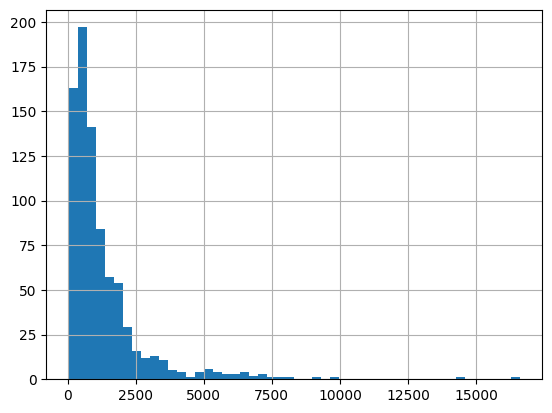

In [8]:
print(df_with_md.shape)
# count the number of words in the md column and plot the histogram
df_with_md["md"].str.split().str.len().hist(bins=50)

# remove the rows where md has less than 100 words
df_with_md = df_with_md[df_with_md["md"].str.split().str.len() > 100]



(809, 3)


<Axes: >

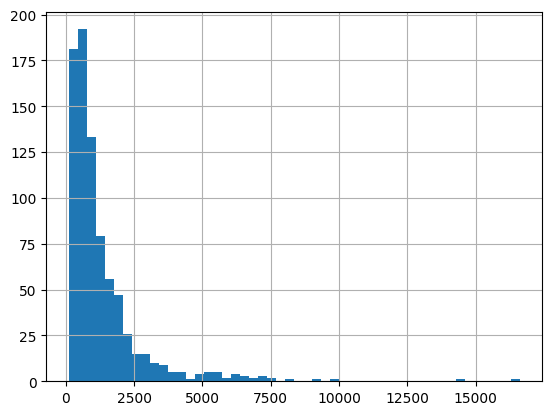

In [9]:
print(df_with_md.shape)
df_with_md["md"].str.split().str.len().hist(bins=50)

In [10]:
# show the 5 rows that has the least number of words
df_with_md.sort_values(by="md").head(5)[["url", "md"]]

,url,md
1649,https://docs.databricks.com/en/,"* [Documentation](#)\n* Databricks documentation\n* \n\n\n\n\n\n\n\n Databricks documentation\n==========================\n\n\n\n December 15, 2023\n \n\n\n\n Databricks documentation provides how-to guidance and reference information for data analysts, data scientists, and data engineers solving problems in analytics and AI. The Databricks Data Intelligence Platform enables data teams to collaborate on data stored in the lakehouse. See\n [What is a data lakehouse?](lakehouse/index.html)\n .\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n**In this article:** \n* [Try Databricks](#try-databricks)\n* [What do you want to do?](#what-do-you-want-to-do)\n* [Manage Databricks](#manage-databricks)\n* [Reference Guides](#reference-guides)\n* [Resources](#resources)\n\n\n\n\n\n Try Databricks\n----------------\n\n\n* [Get a free trial & set up](getting-started/index.html)\n* [Query data from a notebook](getting-started/quick-start.html)\n* [Build a basic ETL pipeline](getting-started/etl-quick-start.html)\n* [Build a simple lakehouse analytics pipeline](getting-started/lakehouse-e2e.html)\n* [Free training](getting-started/free-training.html)\n\n\n\n\n\n What do you want to do?\n-------------------------\n\n\n* [Data science & engineering](workspace-index.html)\n* [Machine learning](machine-learning/index.html)\n* [SQL queries & visualizations](sql/index.html)\n\n\n\n\n\n Manage Databricks\n-------------------\n\n\n* [Account & workspace administration](administration-guide/index.html)\n* [Security & compliance](security/index.html)\n* [Data governance](data-governance/index.html)\n\n\n\n\n\n Reference Guides\n------------------\n\n\n* [API reference](reference/api.html)\n* [SQL language reference](sql/language-manual/index.html)\n* [Error handling and error messages](error-messages/index.html)\n\n\n\n\n\n\n\n\n\n Resources\n-----------\n\n\n* [Release notes](release-notes/index.html)\n* [Other resources](resources/index.html)\n\n\n\n\n\n\n\n\n\n\n\n\n Was this article helpful?\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n---\n\n\n\n\n\n © Databricks 2023. All rights reserved. Apache, Apache Spark, Spark, and the Spark logo are trademarks of the\n [Apache Software Foundation](http://www.apache.org/) \n .\n \n\n\n\n[Send us feedback](mailto:doc-feedback@databricks.com?subject=Documentation Feedback) \n |\n [Privacy Policy](https://databricks.com/privacy-policy) \n |\n [Terms of Use](https://databricks.com/terms-of-use)"
374,https://docs.databricks.com/,"* [Documentation](#)\n* Databricks documentation\n* \n\n\n\n\n\n\n\n Databricks documentation\n==========================\n\n\n\n December 15, 2023\n \n\n\n\n Databricks documentation provides how-to guidance and reference information for data analysts, data scientists, and data engineers solving problems in analytics and AI. The Databricks Data Intelligence Platform enables data teams to collaborate on data stored in the lakehouse. See\n [What is a data lakehouse?](lakehouse/index.html)\n .\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n**In this article:** \n* [Try Databricks](#try-databricks)\n* [What do you want to do?](#what-do-you-want-to-do)\n* [Manage Databricks](#manage-databricks)\n* [Reference Guides](#reference-guides)\n* [Resources](#resources)\n\n\n\n\n\n Try Databricks\n----------------\n\n\n* [Get a free trial & set up](getting-started/index.html)\n* [Query data from a notebook](getting-started/quick-start.html)\n* [Build a basic ETL pipeline](getting-started/etl-quick-start.html)\n* [Build a simple lakehouse analytics pipeline](getting-started/lakehouse-e2e.html)\n* [Free training](getting-started/free-training.html)\n\n\n\n\n\n What do you want to do?\n-------------------------\n\n\n* [Data science & engineering](workspace-index.html)\n* [Machine learning](machine-learning/index.html)\n* [SQL queries & visualizations](sql/index.html)\n\n\n\n\n\n Manage Databricks\n-------------------\n\n\n* [Account & workspace administration](administration-guide/index

(0, 3)


<Axes: >

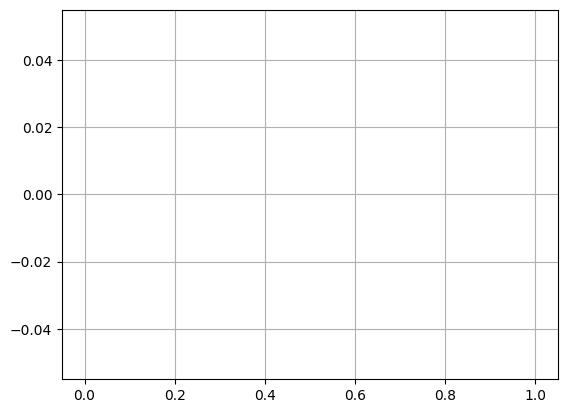

In [11]:
# get rows where the url contains "author"

df_author = df_with_md[df_with_md["url"].str.contains("author")]
print(df_author.shape)

# plot the histogram of the number of words in the md column
df_author["md"].str.split().str.len().hist(bins=50)

In [12]:
# get the row where url is "https://databricks.com/blog/author/anindita-mahapatra/page/15"

df_author[df_author["url"] == "https://databricks.com/blog/author/anindita-mahapatra/page/15"]

,url,content,md
